# Parametrize Core Collapse Supernova (CCSN) yields from different groups


We want to know: how much total metals, and how much iron, are produced as a function of progenitor star mass, at the metallicities of GCs ([Fe/H] ~ -2 to -1).


## nuGrid (Pignatari et al. 2016; ApJS, 225, 24)
Paper: http://adsabs.harvard.edu/abs/2016ApJS..225...24P

Data from: http://www.nugridstars.org/data-and-software/yields

## Heger & West group (C&ocirc;t&eacute; et al. 2016; MNRAS, 465, 3755)
Paper: http://adsabs.harvard.edu/abs/2016MNRAS.463.3755C

Data downloaded from: http://2sn.org/Download/NuGrid/GG/ertl.txt by kind permission of Alexander Heger and Chris West

In [1]:
%matplotlib inline

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [3]:
# Import yield loading code
from nugrid import nugrid
from westheger import westheger

In [4]:
# Code to plot the yields
def yieldplot(ax, masslist, yieldlist, metallist):
    color_map = plt.cm.Set1
    ncolors = 9
    ax.stackplot(masslist, yieldlist, colors=plt.cm.Set1(np.arange(0, 1, 1./ncolors)), linewidth=0)
    # phantom lines for legend
    for ei in xrange(len(metallist)):
        ax.plot([], [], linewidth=5, color=color_map(np.arange(0, 1, 1./ncolors))[ei % ncolors], label=metallist[ei])
        
    # Plot BH09 parametrization for reference
    massax = np.arange(8, 60, 0.5)
    bh09 = (massax > 8.) * (0.0118 + 0.00548*massax)*massax
    
    ax.plot(massax, bh09, 'k-', label='BH09', alpha=0.1, linewidth=5)
    
    ax.set_xlabel('Mass [M$_{\odot}$]')
    ax.set_ylabel('Cumulative Yield [M$_{\odot}$]')
    ax.set_xlim(10, 60)
    ax.set_ylim(0, 7)
    # legend, reversed
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='best')
    

Plot the following yields:

nuGrid: $\log Z/Z_{\odot}$ = -2.2, -1.2, 0.1

WestHeger: $\log Z/Z_{\odot}$ = -2, -1.5, -1, 0

Compare them to the total Z parametrization used in Bailin & Harris (2009):
$(0.0118 + 0.00548 m) m$

The list of elements plotted are the ones that have any appreciable ($>0.1 M_{\odot}$ basically) yield in at least one of these models.

In [5]:
Zsun = 0.0153
nugrid_Z = [0.0001, 0.001, 0.02]
nugrid_Zlabels = ['{0:.1f}'.format(np.log10(x/Zsun)) for x in nugrid_Z]
westheger_Z = [-2, -1.5, -1, 0]
westheger_Zlabels = ['{0:.1f}'.format(x) for x in westheger_Z]

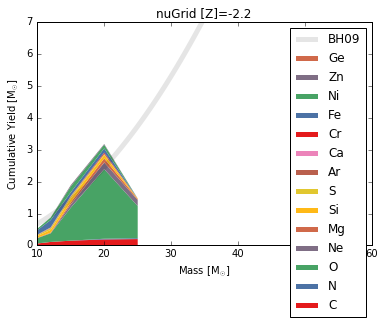

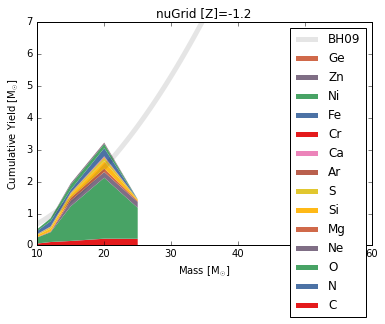

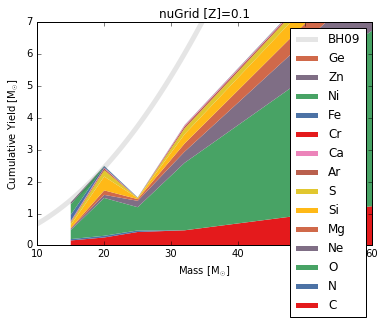

In [6]:
# Plot all nugrid yields
for nuZ, nulab in zip(nugrid_Z, nugrid_Zlabels):
    y = nugrid(nuZ)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    yieldplot(ax, y.masses, y.yields, y.metallist)
    ax.set_title('nuGrid [Z]='+nulab)

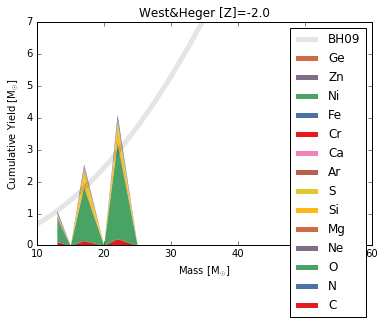

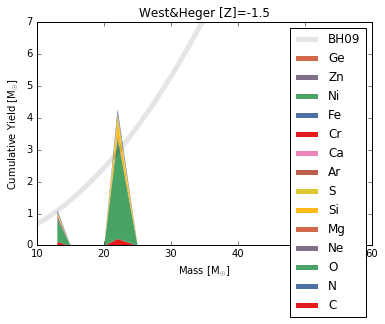

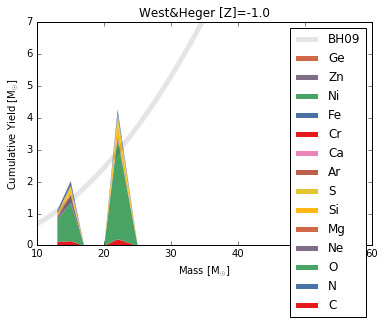

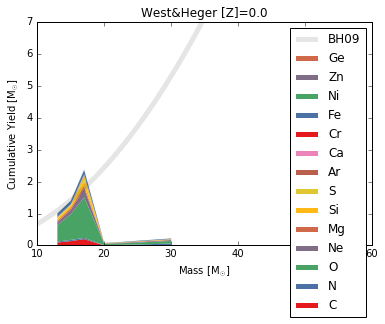

In [7]:
# Plot all WestHeger yields
for whZ, whlab in zip(westheger_Z, westheger_Zlabels):
    y = westheger(whZ)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    yieldplot(ax, y.masses, y.yields, y.metallist)
    ax.set_title('West&Heger [Z]='+whlab)

General notes:
 - At $Z_{\odot}$, BH09 does a decent job below around 20 $M_{\odot}$. Above that, there is fallback which dramatically reduces the yield. Should I believe that? nuGrid yields eventually go back up, though not quite to BH09 levels, while WH yields don't.
 - At lower metallicity, the West & Heger yields are extremely sensitive to mass, sometimes giving failed SNe that don't yield *anything*. I don't know whether to take that seriously. nuGrid models don't do that. Both are in agreement that when there is a yield, it is higher than BH09, especially at 15-20 $M_{\odot}$, but nuGrid yields show the same fallback effect between 20-25 $M_{\odot}$ -- but there are no higher models to see if it recovers.
 - UPDATE: WH yields use the Ertl et al. (2016; ApJ 818, 124) BH formation criteria, which creates "islands of non-explodability", which is responsible for the sawtooth appearance of the yields. Figure 3 of C&ocirc;t&eacute;:
![Cote et al. 2016 Figure 3: Remnant mass as a function of stellar mass and metallicity, showing which models explode versus form black holes](Cote16-f3.png "Cote 16 Figure 3")
Although the presence of non-exploding models might be correct, the details seem very sensitive to numerics. What is an appropriate way of dealing with them?

Update after discussion with Dave Arnett:
 - Yes, there are huge uncertainties. There should also be Geneva group yields, which I might be able to get.
 - On issue of BH formation at random masses -- this is related to effects of mixing, boundary conditions, that give a chaotic system. So details of which precise masses lead to BHs are probably random noise. It is possible that the picture that there are some intermediate mass stars that lead to black holes might be true, but really need to see next generation of models, which will do a much better job of incorporating physics that is seen in 3D hydro simulations, to know in what way.
 - There may be particular constraints that can be had from individual supernovae from light curve fitting. Dave will send paper on this.
 - General plan: Since the yields are so uncertain, a reasonable approach is to adopt 3 sets of yields (e.g. one that produces lots of metals -- maybe the BH09 parametrization, one that's intermediate -- maybe an interpolation of the nuGrid yields, and one that produces very little -- maybe an interpolation of the West & Heger yields) and look at the effects. Possible that this can be used to work backwords and see whether the yields can be constrained?
 - Make sure to caveat heavily about uncertainties.

Create total 3 total metallicity yield functions from this:
 1. BH09
 2. nuGrid
     - Solar metallicity to use the broadest range of models, since the lower metallicity models don't look that different.
     - Extrapolate at lower masses using BH09, at higher masses by just using the 60 $M_{\odot}$ model.
 3. West & Heger
     - [Z]=-1.5 model because it is both a typical GC metallicity and is the most extreme (lowest yield).
     - Extrapolate at lower masses using BH09, assume that at higher masses the yield is zero (everything becomes a black hole).

In [8]:
# Create function for BH09
def bh09_adopted(mass):
    snp = (mass > 8.)
    return snp * (0.0118 + 0.00548*mass)*mass

In [9]:
# Create function that will interpolate nugrid yields
nugrid_adopted_Z = 0.02
nugrid_adopted_y = nugrid(nugrid_adopted_Z)
nugrid_adopted_interpfunc = interp1d(nugrid_adopted_y.masses, nugrid_adopted_y.metaltot, bounds_error=False, fill_value=nugrid_adopted_y.metaltot[-1])
def nugrid_adopted(mass):
    minmass = np.min(nugrid_adopted_y.masses)
    # Use BH09 below minmass, interpolation function above
    return (mass < minmass)*bh09_adopted(mass) + (mass >= minmass)*nugrid_adopted_interpfunc(mass)

In [10]:
# Create function that will interpolate West & Heger yields
wh_adopted_Z = -1.5
wh_adopted_y = westheger(wh_adopted_Z)
wh_adopted_interpfunc = interp1d(wh_adopted_y.masses, wh_adopted_y.metaltot, bounds_error=False, fill_value=0.0)
def wh_adopted(mass):
    minmass = np.min(wh_adopted_y.masses)
    # Use BH09 below minmass, interpolation function above
    return (mass < minmass)*bh09_adopted(mass) + (mass >= minmass)*wh_adopted_interpfunc(mass)

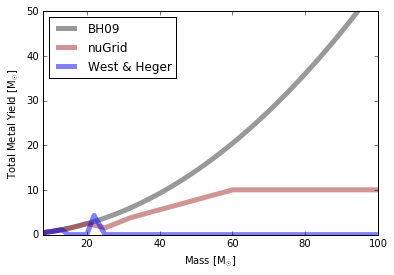

In [11]:
# Plot the three adopted yield functions
plt.figure()
massax = np.arange(8,120,0.1)
plt.plot(massax, bh09_adopted(massax), color='black', label='BH09', alpha=0.4, linewidth=5)
plt.plot(massax, nugrid_adopted(massax), color='brown', label='nuGrid', alpha=0.5, linewidth=5)
plt.plot(massax, wh_adopted(massax), color='blue', label='West & Heger', alpha=0.5, linewidth=5)
plt.legend(loc='best')
plt.xlabel('Mass [M$_{\odot}$]')
plt.ylabel('Total Metal Yield [M$_{\odot}$]')
plt.xlim(8,100)
plt.ylim(0,50);

In the context of the enrichment due to these yields, the total metals produced is the convolution of the yield per CCSN and the IMF $dn/dm \equiv \xi(m) = A m^\alpha$, with $\alpha = -2.35$. As described in BH09, we assume $m_{\mathrm{min}}=0.3~M_{\odot}$ and $m_{\mathrm{max}}=100~M_{\odot}$ so that we get the slope at the high mass end right and get the correct number of supernovae per solar mass of stars formed.

Normalization: for every $1~M_{\odot}$ of material produced, $A = \frac{\alpha +2}{m_{\mathrm{max}}^{\alpha+2} - m_{\mathrm{min}}^{\alpha+2}}$

Total amount of metals produced by stars of mass $>m$
$$ M_Z(>m) = \int_m^{m_{\mathrm{max}}} m_Z(m')\, \xi(m')\, dm' $$

Total amount of metals produced period
$$ M_Z = M_Z(>m_{\mathrm{min}}) $$

Total amount of metals produced after time $t$
$$ M_Z(t) = M_Z(>m_{t}) $$
where $m_t$ is the most massive star still alive after time $t$, i.e. the lifetime of a star with mass $m_t$ is $t$.

Taking lifetimes from [Massive Star Lifetimes](../stellar-lifetimes/Massive Star Lifetimes.ipynb):
$$\log\tau = -0.086 (\log m)^3 + 0.95 (\log m)^2 - 3.17 \log m + 9.77$$

In [12]:
# Define IMF
imf_alpha = -2.35
imf_mmin = 0.3
imf_mmax = 100.0

def imf_xi(m):
    aplus2 = imf_alpha + 2.0
    A = aplus2/(imf_mmax**aplus2 - imf_mmin**aplus2)
    return A * m**imf_alpha
# Define cumulative metals produced by stars of mass >m
def cumulative_metals_starmass(m, yieldfunc):
    integrand = lambda x: yieldfunc(x) * imf_xi(x)
    return quad(integrand, m, imf_mmax)[0]
# Define cumulative metals produced by stars with lifetimes <t
def lifetime_polyfit(m):
    lm = np.log10(m)
    return 10.0**(-0.086 * lm**3 + 0.95 * lm**2 - 3.17 * lm + 9.77)
mmx = np.arange(imf_mmin, imf_mmax, 0.01)
tmx = lifetime_polyfit(mmx)
stargoboomnow = interp1d(tmx, mmx, bounds_error=False, fill_value=(imf_mmax+1., imf_mmin-1.,))
def cumulative_metals_time(time, yieldfunc):
    return cumulative_metals_starmass(stargoboomnow(time), yieldfunc)

/Users/jbailin/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/jbailin/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


(0, 0.04)

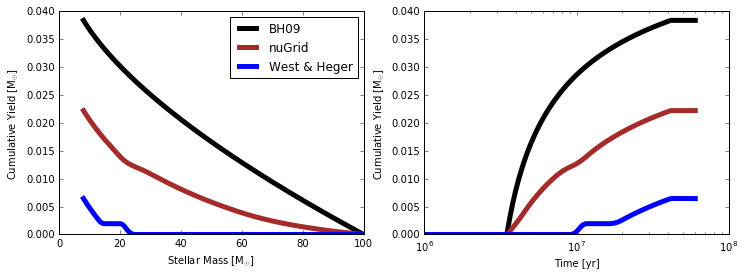

In [13]:
# Plot the cumulative production as a function of stellar mass and time.
fig = plt.figure()
figsize = fig.get_size_inches()
figsize[0] *= 2
fig.set_size_inches(figsize)
axmass = fig.add_subplot(121)
massax = np.arange(8, 100, 0.2)
axmass.plot(massax, [cumulative_metals_starmass(x, bh09_adopted) for x in massax], color='black', label='BH09', linewidth=5)
axmass.plot(massax, [cumulative_metals_starmass(x, nugrid_adopted) for x in massax], color='brown', label='nuGrid', linewidth=5)
axmass.plot(massax, [cumulative_metals_starmass(x, wh_adopted) for x in massax], color='blue', label='West & Heger', linewidth=5)
axmass.set_ylim(0,0.04)
axmass.legend(loc='best')
axmass.set_xlabel('Stellar Mass [M$_{\odot}$]')
axmass.set_ylabel('Cumulative Yield [M$_{\odot}$]')
axtime = fig.add_subplot(122)
timeax = 10.0**(np.arange(6, 7.8, 0.02))
axtime.plot(timeax, [cumulative_metals_time(x, bh09_adopted) for x in timeax], color='black', label='BH09', linewidth=5)
axtime.plot(timeax, [cumulative_metals_time(x, nugrid_adopted) for x in timeax], color='brown', label='nuGrid', linewidth=5)
axtime.plot(timeax, [cumulative_metals_time(x, wh_adopted) for x in timeax], color='blue', label='West & Heger', linewidth=5)
axtime.set_xlabel('Time [yr]')
axtime.set_ylabel('Cumulative Yield [M$_{\odot}$]')
axtime.set_xscale('log')
axtime.set_ylim(0,0.04)


Iron Fraction
-------------
For the first round of GCZCSE, I am nominally looking at iron, really as a tracer for total metallicity. Let's look at whether looking explicitly at iron, either in terms of total mass or in terms of the fraction of the total yield, is useful.

(10, 50)

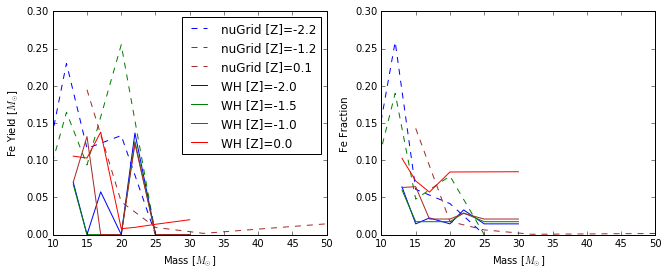

In [14]:
# Get some plot variables ready for colours/linestyles.
Zcolors = ['blue', 'green', 'brown', 'red']
nugrid_style = '--'
westheger_style = '-'
fig = plt.figure()
figsize = fig.get_size_inches()
figsize[0] *= 1.8
fig.set_size_inches(figsize)
ax_tot = fig.add_subplot(121)
ax_frac = fig.add_subplot(122)
ax_tot.set_xlabel('Mass [$M_{\odot}$]')
ax_tot.set_ylabel('Fe Yield [$M_{\odot}$]')
ax_frac.set_xlabel('Mass [$M_{\odot}$]')
ax_frac.set_ylabel('Fe Fraction')

# nuGrid yields
for Z,lab,c in zip(nugrid_Z, nugrid_Zlabels, Zcolors):
    y = nugrid(Z)
    ironindex = y.metallist.index('Fe')
    ax_tot.plot(y.masses, y.yields[ironindex,:], color=c, linestyle=nugrid_style, label='nuGrid [Z]={0}'.format(lab))
    ax_frac.plot(y.masses, y.yields[ironindex,:]/y.metaltot, color=c, linestyle=nugrid_style)
# WestHeger yields
for Z,lab,c in zip(westheger_Z, westheger_Zlabels, Zcolors):
    y = westheger(Z)
    ironindex = y.metallist.index('Fe')
    ax_tot.plot(y.masses, y.yields[ironindex,:], color=c, linestyle=westheger_style, label='WH [Z]={0}'.format(lab))
    ax_frac.plot(y.masses, y.yields[ironindex,:]/y.metaltot, color=c, linestyle=westheger_style)

ax_tot.legend(loc='best')
ax_frac.set_xlim(10,50)
ax_tot.set_xlim(10,50)


Summary:
 - Absolute iron yields are a giant mass. Don't use them.
 - Fractional yields paint a somewhat better picture... drops from 0.2-0.25 at 10 M$_{\odot}$ to "lower". But how fast, and to what level, depends on the model and metallicity. West & Heger plateaus to 0.02 at low metallicity, but nuGrid really drop to almost zero when there is significant fallback.
 - Total metallicity looks nicer in nuGrid, but iron fraction looks better in West & Heger. Given that they both agree on total metallicity when the West & Heger models explode, it's not crazy to use nuGrid to parametrize total metallicity and then use the 0.02 Fe fraction from WH. I think. But again, not sure how seriously to take these numbers.